In this version of the project, I replace the NaNs first, then I drop the duplicates.  I ended with cleaning and hypothesis testing.  The results of the chi-square test in this notebook are very similar to those in notebook 1.  It does not seem to be the case that replacing NaN first and dropping duplicates before cleaning the variables affected the results of the hypotheses tests. 

Interestingly, the encoded dataframe in this notebook includes 17,748 observations whereas in the first notebook, I had 15,736.  This is due the the cleaning of days_employed before replacing missing values. When that was done, all the observations less than 23k were dropped in both notebooks.  However, in the current notebook, the replaced missing values remained.  I guess there is always a tradeoff.  In my opinion the flow of the method in notebook 1 is superior because the median in the pivot tables (had they existed) would have been based on realistic values.  Whereas in this notebook, although we gained observations, their meaning is questionable because they are based on medians that are unrealistic.

In [1]:
import pandas as pd
 
try:
    credit = pd.read_csv("credit_scoring_eng.csv")
except:
    credit = pd.read_csv('/datasets/credit_scoring_eng.csv') 
credit.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
5,0,-926.185831,27,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house
6,0,-2879.202052,43,bachelor's degree,0,married,0,F,business,0,38484.156,housing transactions
7,0,-152.779569,50,SECONDARY EDUCATION,1,married,0,M,employee,0,21731.829,education
8,2,-6929.865299,35,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,15337.093,having a wedding
9,0,-2188.756445,41,secondary education,1,married,0,M,employee,0,23108.150,purchase of the house for my family


In [2]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Conclusion: There are 11 variables in total.  Some are integers, others are floats and the rest are objects.  Both total_income and days_employed have the same amount of missing values, though we cannot tell if the same rows have the same values.  If that is the case, these missing data are not random and could be problematic.

In [3]:
credit.describe() 

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,19351.000000
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,26787.568355
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,16475.450632
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,3306.762000
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,16488.504500
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,23202.870000
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,32549.611000
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,362496.645000


Conclusion: Variable "children" is problematic because it has negative values and values above 20.  Though it is not impossible for a family to have 20 kids, more investigation should reveal if this is an error or just an outlier. Days employed is too problematic.  401755/365 is 1100 years; obviously there is a problem here.  No entry should be greater than say 60*365 or around 22000.  Also, negative days employed we are told do not refer to unemployment or retirement hence they should be fixed by taking their absolute value.  "dob_years" we are told refers to age in years, so any age below 18, the working age, is problematic.  We have age 0.  total_income refers to total individual income.  Its distribution is problematic.  The mean of 20000 observation is 26k when the max is 362k.  This data is skewed and one should look at its std to have an idea of the amount of skewness.

Following the project guidelines before curating the data:
1- lower case
2- take absolute value of income
3- create pivot tables based on the median to replace NaNs in some variables
4- create a function that extracts median values based on the conditions set in the pivot tables.
5- categorize

In [4]:
list = ["education", "family_status", "gender", "income_type", "purpose"]

for i in list:
    credit[i] = credit[i].str.lower()
credit.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,f,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,f,employee,0,17932.802,car purchase
2,0,-5623.422610,33,secondary education,1,married,0,m,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,m,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,f,retiree,0,25378.572,to have a wedding


In [5]:
credit['days_employed'] = abs(credit['days_employed'])

Steps for tackling the missing data:

1- logic for income imputation: Political science theory posits that income is a function of education, gender, age, but also other variables not in our dataset like race.  Therefore, any imputation of income should account to these variables.

2- logic for days_employment imputation: employees that miss work is due to low wages and children. These are often women.

3- I create a pivot table based on the median.  This will allow me to impute values based on other variables.  

4- I then create a function that loops over the dataframe and replaces NaN values with values from the pivot table.

In [6]:
credit.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

The 2 variables that have missing data are "days-employed" and "total_income".

In [7]:
null_data = credit[credit.isnull().any(axis=1)]
null_data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,secondary education,1,civil partnership,1,m,retiree,0,NaN,to have a wedding
26,0,NaN,41,secondary education,1,married,0,m,civil servant,0,NaN,education
29,0,NaN,63,secondary education,1,unmarried,4,f,retiree,0,NaN,building a real estate
41,0,NaN,50,secondary education,1,married,0,f,civil servant,0,NaN,second-hand car purchase
55,0,NaN,54,secondary education,1,civil partnership,1,f,retiree,1,NaN,to have a wedding
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,secondary education,1,married,0,m,business,0,NaN,purchase of a car
21495,1,NaN,50,secondary education,1,civil partnership,1,f,employee,0,NaN,wedding ceremony
21497,0,NaN,48,bachelor's degree,0,married,0,f,business,0,NaN,building a property
21502,1,NaN,42,secondary education,1,married,0,f,employee,0,NaN,building a real estate


In [8]:
null_data['days_employed'].unique()

array([nan])

In [9]:
null_data['total_income'].unique()

array([nan])

Conclusion: Interestingly, the same observations have both variables missing.  This means the patterns of missing variables is not random and hence is problematic.  The contents of the cells with missing variables are all nans.

Create pivot table to replace the NaNs.  I choose the median instead of the mean because the income data is very skewed.  

In [10]:
pivot_median_income = credit.pivot_table(index = [ 'dob_years', 'gender'], 
                   columns = 'education', values = 'total_income', 
                   aggfunc = "median")
pivot_median_income


education         bachelor's degree  graduate degree  primary education  \
dob_years gender                                                          
0         f              24867.3015              NaN                NaN   
          m              33861.6755              NaN                NaN   
19        f                     NaN              NaN                NaN   
          m                     NaN              NaN                NaN   
20        f              14251.5510              NaN                NaN   
...                             ...              ...                ...   
72        m              25497.3920              NaN                NaN   
73        f                     NaN              NaN           16026.66   
74        f              21589.6570              NaN                NaN   
          m                     NaN              NaN                NaN   
75        f                     NaN              NaN                NaN   

education         secondary education  some college  
dob_years gender                                     
0         f                17587.7440     20519.463  
          m                26641.5805     40971.287  
19        f                17954.8410     19686.494  
          m                14817.5910     14575.717  
20        f                16441.5260     13850.468  
...                               ...           ...  
72        m                17362.0700           NaN  
73        f                19663.4950           NaN  
74        f                 7214.3270           NaN  
          m                14366.7860           NaN  
75        f                24525.2240           NaN  

[115 rows x 5 columns]

In [11]:
# create a replace_na function to use the apply() function per row of dataframe
def replace_na(row): 
    education = row["education"] 
    #income_type = row["income_type"] 
    gender = row["gender"] 
    age = row['dob_years']
    if pd.isnull(row['total_income']):
        #print(education, age, gender)
        return pivot_median_income[education][age][gender]
    else: 
        return row['total_income']


credit["income"] = credit.apply(replace_na, axis=1)
credit

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income
0,1,8437.673028,42,bachelor's degree,0,married,0,f,employee,0,40620.102,purchase of the house,40620.102
1,1,4024.803754,36,secondary education,1,married,0,f,employee,0,17932.802,car purchase,17932.802
2,0,5623.422610,33,secondary education,1,married,0,m,employee,0,23341.752,purchase of the house,23341.752
3,3,4124.747207,32,secondary education,1,married,0,m,employee,0,42820.568,supplementary education,42820.568
4,0,340266.072047,53,secondary education,1,civil partnership,1,f,retiree,0,25378.572,to have a wedding,25378.572
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529.316663,43,secondary education,1,civil partnership,1,f,business,0,35966.698,housing transactions,35966.698
21521,0,343937.404131,67,secondary education,1,married,0,f,retiree,0,24959.969,purchase of a car,24959.969
21522,1,2113.346888,38,secondary education,1,civil partnership,1,m,employee,1,14347.610,property,14347.610
21523,3,3112.481705,38,secondary education,1,married,0,m,employee,1,39054.888,buying my own car,39054.888


In [12]:
pivot_median_days_employed = credit.pivot_table(index = [ 'gender'], 
                   columns = 'children', values = 'days_employed', 
                   aggfunc = "median")
pivot_median_days_employed

children,-1,0,1,2,3,4,5,20
gender,,,,,,,,
f,2674.727216,3298.254825,1800.377349,1665.814753,1871.817349,1793.417086,773.124856,2047.754733
m,2756.319014,1747.471555,1481.563083,1712.886722,1666.148894,2404.904890,1690.018117,1039.186009
xna,NaN,2358.600502,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#create a replace_na function to use the apply() function per row of dataframe
def replace_na(row): 
    #income = row["income"] 
    gender = row["gender"] 
    children = row['children']
    if pd.isnull(row['days_employed']):
        #print(children, gender, income)
        return pivot_median_days_employed[children][gender]
    else: 
        return row['days_employed']


credit["days_empl"] = credit.apply(replace_na, axis=1)
credit

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income,days_empl
0,1,8437.673028,42,bachelor's degree,0,married,0,f,employee,0,40620.102,purchase of the house,40620.102,8437.673028
1,1,4024.803754,36,secondary education,1,married,0,f,employee,0,17932.802,car purchase,17932.802,4024.803754
2,0,5623.422610,33,secondary education,1,married,0,m,employee,0,23341.752,purchase of the house,23341.752,5623.422610
3,3,4124.747207,32,secondary education,1,married,0,m,employee,0,42820.568,supplementary education,42820.568,4124.747207
4,0,340266.072047,53,secondary education,1,civil partnership,1,f,retiree,0,25378.572,to have a wedding,25378.572,340266.072047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529.316663,43,secondary education,1,civil partnership,1,f,business,0,35966.698,housing transactions,35966.698,4529.316663
21521,0,343937.404131,67,secondary education,1,married,0,f,retiree,0,24959.969,purchase of a car,24959.969,343937.404131
21522,1,2113.346888,38,secondary education,1,civil partnership,1,m,employee,1,14347.610,property,14347.610,2113.346888
21523,3,3112.481705,38,secondary education,1,married,0,m,employee,1,39054.888,buying my own car,39054.888,3112.481705


In [14]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
 12  income            21522 non-null  float64
 13  days_empl         21525 non-null  float64
dtypes: float64(4), int64(5), object(5)
memory usage: 2.3+ MB


In [15]:
credit.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
income                 3
days_empl              0
dtype: int64

For some reason, there are still 3 missing values in income.  Can you please explain?

In [16]:
credit[credit['income'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income,days_empl
11369,2,NaN,31,primary education,3,married,0,f,employee,1,NaN,transactions with my real estate,NaN,1665.814753
17696,1,NaN,45,primary education,3,married,0,f,retiree,0,NaN,real estate transactions,NaN,1800.377349
18739,0,NaN,62,some college,2,civil partnership,1,m,business,0,NaN,to have a wedding,NaN,1747.471555


I will drop those rows.

In [17]:
credit = credit.drop(labels=[11369,17696,18739], axis=0)

Now I drop the original columns that had the NaN values.

In [18]:
credit = credit.drop(['days_employed', "total_income"], axis = 1)
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21522 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21522 non-null  int64  
 1   dob_years         21522 non-null  int64  
 2   education         21522 non-null  object 
 3   education_id      21522 non-null  int64  
 4   family_status     21522 non-null  object 
 5   family_status_id  21522 non-null  int64  
 6   gender            21522 non-null  object 
 7   income_type       21522 non-null  object 
 8   debt              21522 non-null  int64  
 9   purpose           21522 non-null  object 
 10  income            21522 non-null  float64
 11  days_empl         21522 non-null  float64
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


Dropping the duplicates

In [19]:
credit.drop_duplicates(keep=False, inplace=True)

In [20]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21385 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21385 non-null  int64  
 1   dob_years         21385 non-null  int64  
 2   education         21385 non-null  object 
 3   education_id      21385 non-null  int64  
 4   family_status     21385 non-null  object 
 5   family_status_id  21385 non-null  int64  
 6   gender            21385 non-null  object 
 7   income_type       21385 non-null  object 
 8   debt              21385 non-null  int64  
 9   purpose           21385 non-null  object 
 10  income            21385 non-null  float64
 11  days_empl         21385 non-null  float64
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


In [21]:
credit.duplicated().sum()

0

We lost 137 observation that were duplicated

In [22]:
print('children', credit['children'].unique())
print(credit['children'].value_counts())

children [ 1  0  3  2 -1  4 20  5]
 0     14037
 1      4797
 2      2048
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64


It does not make sense to have a negative child.
It is not commonsensical for 76 families in our dataset to have 20 kids when 9 families only have 5 and there is nothing in between.

In [23]:
credit = credit[(credit['children'] != -1) & (credit['children'] != 20)]
print(credit['children'].value_counts())
credit.info()

0    14037
1     4797
2     2048
3      330
4       41
5        9
Name: children, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21262 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21262 non-null  int64  
 1   dob_years         21262 non-null  int64  
 2   education         21262 non-null  object 
 3   education_id      21262 non-null  int64  
 4   family_status     21262 non-null  object 
 5   family_status_id  21262 non-null  int64  
 6   gender            21262 non-null  object 
 7   income_type       21262 non-null  object 
 8   debt              21262 non-null  int64  
 9   purpose           21262 non-null  object 
 10  income            21262 non-null  float64
 11  days_empl         21262 non-null  float64
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


We lost another 123 observations

In [24]:
print("gender:", credit['gender'].unique())

gender: ['f' 'm' 'xna']


I am assuming xna is binary in this case and keep the observation.

In [25]:
credit['purpose'].value_counts().sort_values(ascending=False)

wedding ceremony                            784
having a wedding                            756
to have a wedding                           751
real estate transactions                    670
buy commercial real estate                  655
buying property for renting out             647
housing transactions                        646
transactions with commercial real estate    644
housing                                     640
purchase of the house                       639
purchase of the house for my family         634
property                                    630
construction of own property                628
purchase of my own house                    619
transactions with my real estate            619
building a real estate                      618
building a property                         618
buy real estate                             613
housing renovation                          601
buy residential real estate                 601
buying my own car                       

In [26]:
credit['purpose'] = credit['purpose'].replace(['wedding ceremony','having a wedding'], 'to have a wedding')
credit['purpose'] = credit['purpose'].replace(['purchase of a car', 'cars', 'buying a second-hand car', 'second-hand car purchase', 'car', 'to own a car', 'buying my own car', "car purchase"], 'to buy a car')
credit['purpose'] = credit['purpose'].replace(['real estate', 'buy real estate','housing renovation', 'construction of own property',  'buy residential real estate','housing transactions', 'transactions with my real estate', 'purchase of the house',  'real estate transactions', 'purchase of my own house', 'buy commercial real estate', 'buying property for renting out', 'transactions with commercial real estate', 'building a property', 'building a real estate', 'purchase of the house for my family', 'housing', 'property' ], 'for real estate transaction')
credit['purpose'] = credit['purpose'].replace(['going to university', 'university education','education', 'supplementary education', 'getting higher education', 'getting an education', 'profile education', 'to get a supplementary education',  'to become educated'  ], 'to get an education')
credit['purpose'].value_counts()

for real estate transaction    10722
to buy a car                    4270
to get an education             3979
to have a wedding               2291
Name: purpose, dtype: int64

In [27]:
print("education:", credit['education'].unique())

education: ["bachelor's degree" 'secondary education' 'some college'
 'primary education' 'graduate degree']


In [28]:
print("family_status", credit['family_status'].unique())

family_status ['married' 'civil partnership' 'widow / widower' 'divorced' 'unmarried']


In [29]:
print("family_status_id", credit['family_status_id'].unique())

family_status_id [0 1 2 3 4]


Family status is already encoded.  I will drop the "family_status" variable from the dataframe later.  

days of employment [8437.67302776 4024.80375385 5623.42261023 ... 2113.3468877  3112.4817052
 1984.50758853]


<AxesSubplot:>

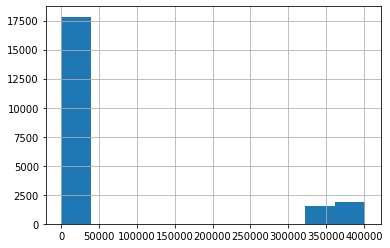

In [30]:
print('days of employment', credit['days_empl'].unique())
credit['days_empl'].hist()

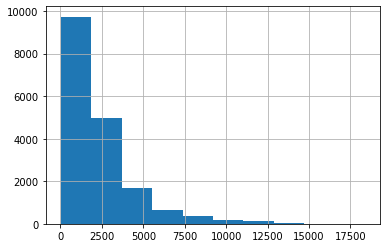

In [80]:
credit['days_empl'].hist();

If we assume that the older person in the dataset who is 75 was 10 years old and worked in his/her parent business, then we can use 65 years as the maximum number of years of employment and multiply that by 365 - assuming of course that these days employed include weekends.  This step removes most of the NaNs.

23725
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17831 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          17831 non-null  int64  
 1   dob_years         17831 non-null  int64  
 2   education         17831 non-null  object 
 3   education_id      17831 non-null  int64  
 4   family_status     17831 non-null  object 
 5   family_status_id  17831 non-null  int64  
 6   gender            17831 non-null  object 
 7   income_type       17831 non-null  object 
 8   debt              17831 non-null  int64  
 9   purpose           17831 non-null  object 
 10  income            17831 non-null  float64
 11  days_empl         17831 non-null  float64
dtypes: float64(2), int64(5), object(5)
memory usage: 1.8+ MB


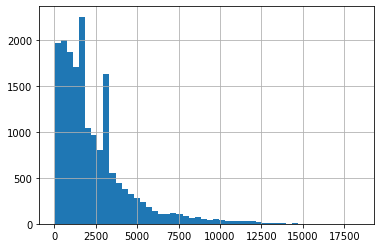

In [31]:
print(65*365)
credit = credit[(credit['days_empl'] < 23725) ]
type(credit)
credit['days_empl'].hist(bins = 50)
credit.info()

Here were lost 3431 observations compared to 5593 in notebook 1 which I am assuming dropped also all the NaN values.

Now I categorize days employed.

In [32]:
def empl_len(employment):
    
    if employment <= 500:
        return 'upto500'
    if employment <= 1000:
        return 'upto1000'
    if employment <= 1500:
        return 'upto1500'
    if employment <= 2000:
        return 'upto2000'
    if employment <= 3000:
        return 'upto3000'
    if employment <= 5000:
        return 'upto5000'
    return 'above5000+'

credit['empl_len'] = credit['days_empl'].apply(empl_len)
print(credit['empl_len'].value_counts())

upto5000      3401
upto2000      2673
upto500       2599
upto1000      2593
upto3000      2446
upto1500      2357
above5000+    1762
Name: empl_len, dtype: int64


In [33]:
#credit['days_employed'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
#credit['days_employed'].quantile([.2,  .4,  .6,  .8])
credit['days_empl'].quantile([.15, .3, .45, .6, .75, .9])

0.15     513.782385
0.30    1027.220678
0.45    1624.196920
0.60    2182.448451
0.75    3298.254825
0.90    4973.693154
Name: days_empl, dtype: float64

Here too I am happy with my choice.

<AxesSubplot:>

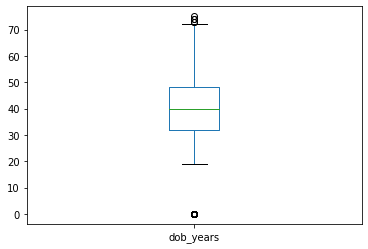

In [34]:
credit.boxplot(column =['dob_years'], grid = False)

<AxesSubplot:>

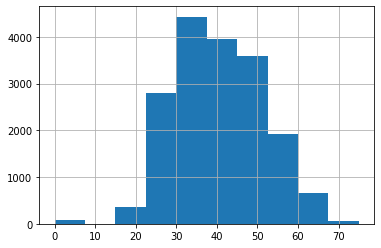

In [35]:
credit['dob_years'].hist()

An observation with age == 0 is nonsensical.  Obvisouly it is a mistake. 

In [36]:
credit = credit[(credit['dob_years'] >= 18) ]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17748 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          17748 non-null  int64  
 1   dob_years         17748 non-null  int64  
 2   education         17748 non-null  object 
 3   education_id      17748 non-null  int64  
 4   family_status     17748 non-null  object 
 5   family_status_id  17748 non-null  int64  
 6   gender            17748 non-null  object 
 7   income_type       17748 non-null  object 
 8   debt              17748 non-null  int64  
 9   purpose           17748 non-null  object 
 10  income            17748 non-null  float64
 11  days_empl         17748 non-null  float64
 12  empl_len          17748 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 1.9+ MB


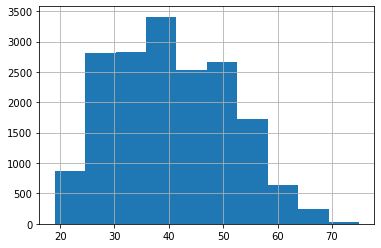

In [37]:
credit['dob_years'].hist()
credit.info()

This time we lost 83 observations.

Now, I will categorize age.  There is no right and wrong way to do this. The more categories, the more texture in the data and the better hypothesis testing is.  But we are restricted to our data and its bulk is between 22 and 60.  So I choose the following.

In [38]:
def age_group(age):
    
   
    if age <= 25:
        return 'upto25'
    if age <= 30:
        return 'upto30'
    if age <= 35:
        return 'upto35'
    if age <= 40:
        return 'upto40'
    if age <= 45:
        return 'upto45'
    if age <= 50:
        return 'upto50'
    if age <= 55:
        return 'upto55'
    return '55+'

credit['age_group'] = credit['dob_years'].apply(age_group)
print(credit['age_group'].value_counts())

upto35    2829
upto40    2815
upto45    2682
upto30    2463
upto50    2348
upto55    1715
55+       1672
upto25    1224
Name: age_group, dtype: int64


To check my intuition, I view the distribution of this variable's quantiles.

In [39]:
#credit['dob_years'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
#credit['dob_years'].quantile([.2,  .4,  .6,  .8])
credit['dob_years'].quantile([.15, .3, .45, .6, .75, .9])

0.15    29.0
0.30    34.0
0.45    38.0
0.60    43.0
0.75    48.0
0.90    55.0
Name: dob_years, dtype: float64

I am happy with my decision.  Even the 10% quantile starts at 27.

In [40]:
print('education_id', credit['education_id'].unique())

education_id [0 1 2 3 4]


Here too, "education" is already encoded.

In [41]:
print('income_type', credit['income_type'].unique())

income_type ['employee' 'business' 'retiree' 'civil servant' 'entrepreneur' 'student'
 'paternity / maternity leave']


In [42]:
print('debt', credit['debt'].unique())

debt [0 1]


This is our dependent variable of interest and it is dichotomous.  So our explanatory variables need not be continuous and categorizing is the right thing to do.

<AxesSubplot:>

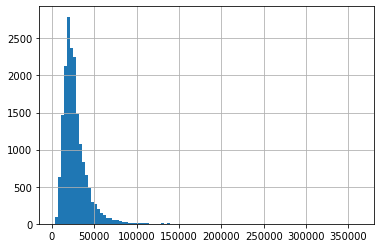

In [43]:
credit['income'].hist(bins=100)

<AxesSubplot:>

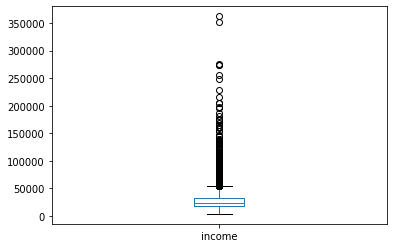

In [44]:
credit.boxplot(column =['income'], grid = False)

This data is very skewed and the categorization should capture these nuances in the data.

In [45]:
def income_group(income):
    
    if income <= 15000:
        return 'bracket15'
    if income <= 20000:
        return 'bracket20'
    if income <= 25000:
        return 'bracket25'
    if income <= 35000:
        return 'bracket35'
    if income <= 45000:
        return 'bracket45'
    return 'bracket45+'

credit['income_group'] = credit['income'].apply(income_group)
print(credit['income_group'].value_counts())

bracket35     4573
bracket25     3582
bracket20     3325
bracket15     2600
bracket45     1996
bracket45+    1672
Name: income_group, dtype: int64


In [46]:
#credit['total_income'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
#credit['total_income'].quantile([.2,  .4,  .6,  .8])
credit['income'].quantile([.15, .3, .45, .6, .75, .9])

0.15    15124.2779
0.30    19267.9553
0.45    22521.6597
0.60    26584.9732
0.75    32416.9890
0.90    44284.1439
Name: income, dtype: float64

Here again our data is skewed and I am happy with my choice.

Now I create a duplicate from my dataframe in order to replace some columns with their encoded equivalent and drop the variables that are already encoded.

In [47]:
credit_encode = credit.copy()

In [48]:
# encoding gender and placing it in credit_encode
gender_encode = {'gender':{'f': 0, "m": 1, 'xna': 2}}
print(gender_encode)
credit_encode.replace(gender_encode, inplace =True)

{'gender': {'f': 0, 'm': 1, 'xna': 2}}


In [49]:
# encoding 'purpose' and placing it in credit_encode
purpose_encode = {'purpose':{'for real estate transaction': 0, "to buy a car": 1, 'to get an education': 2, 'to have a wedding':3}}
print(purpose_encode)
credit_encode.replace(purpose_encode, inplace =True)

{'purpose': {'for real estate transaction': 0, 'to buy a car': 1, 'to get an education': 2, 'to have a wedding': 3}}


In [50]:
# encoding 'age_group' and placing it in credit_encode
age_group_encode = {'age_group':{'upto25': 0,'upto30': 1, "upto35": 2, 'upto40': 3, 'upto45':4, 'upto50':5, 'upto55':6, '55+':7}}
print(age_group_encode)
credit_encode.replace(age_group_encode, inplace =True)

{'age_group': {'upto25': 0, 'upto30': 1, 'upto35': 2, 'upto40': 3, 'upto45': 4, 'upto50': 5, 'upto55': 6, '55+': 7}}


In [51]:
# encoding 'income_type' and placing it in credit_encode
income_type_encode = {'income_type':{'employee':0, 'business':1, 'civil servant':2, 'student':3, 'entrepreneur':4,
 'paternity / maternity leave':5, 'retiree':6}}
print(income_type_encode)
credit_encode.replace(income_type_encode, inplace =True)

{'income_type': {'employee': 0, 'business': 1, 'civil servant': 2, 'student': 3, 'entrepreneur': 4, 'paternity / maternity leave': 5, 'retiree': 6}}


In [52]:
# encoding 'total_income' and placing it in credit_encode
total_income_encode = {'income_group':{'bracket15':0, 'bracket20':1, 'bracket25':2, 'bracket35':3,'bracket45':4, 'bracket45+':5}}
print(total_income_encode)
credit_encode.replace(total_income_encode, inplace =True)

{'income_group': {'bracket15': 0, 'bracket20': 1, 'bracket25': 2, 'bracket35': 3, 'bracket45': 4, 'bracket45+': 5}}


In [53]:
# encoding 'days_employed' and placing it in credit_encode
days_employed_encode = {'empl_len':{'upto500':0, 'upto1000':1, 'upto1500':2, 'upto2000':3, 'upto3000':4, 'upto5000':5, 'above5000+':6}}
print(days_employed_encode)
credit_encode.replace(days_employed_encode, inplace =True)

{'empl_len': {'upto500': 0, 'upto1000': 1, 'upto1500': 2, 'upto2000': 3, 'upto3000': 4, 'upto5000': 5, 'above5000+': 6}}


Here I drop those columns that have been replaced with their encoded equivalent.

In [54]:
credit_encode.drop([ "dob_years", "education", "family_status",  "income", "days_empl"], axis = 1, inplace = True) 
credit_encode

,children,education_id,family_status_id,gender,income_type,debt,purpose,empl_len,age_group,income_group
0,1,0,0,0,0,0,0,6,4,4
1,1,1,0,0,0,0,1,5,3,1
2,0,1,0,1,0,0,0,6,2,2
3,3,1,0,1,0,0,2,5,2,4
5,0,0,1,1,1,0,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...
21519,1,4,3,1,0,0,0,4,3,1
21520,1,1,1,0,1,0,0,5,4,4
21522,1,1,1,1,0,1,0,4,3,0
21523,3,1,0,1,0,1,1,5,3,4


Check the encoding for errors.

In [55]:
for col in credit_encode:
    print(credit_encode[col].unique())

[1 0 3 2 4 5]
[0 1 2 3 4]
[0 1 3 4 2]
[0 1 2]
[0 1 6 2 4 3 5]
[0 1]
[0 1 2 3]
[6 5 1 4 0 3 2]
[4 3 2 1 5 7 6 0]
[4 1 2 0 3 5]


Check for null.

In [56]:
credit_encode.isnull().sum()

children            0
education_id        0
family_status_id    0
gender              0
income_type         0
debt                0
purpose             0
empl_len            0
age_group           0
income_group        0
dtype: int64

Integerize the dataframe in preparation for testing hypotheses.

In [57]:
credit_encode.apply(pd.to_numeric)

,children,education_id,family_status_id,gender,income_type,debt,purpose,empl_len,age_group,income_group
0,1,0,0,0,0,0,0,6,4,4
1,1,1,0,0,0,0,1,5,3,1
2,0,1,0,1,0,0,0,6,2,2
3,3,1,0,1,0,0,2,5,2,4
5,0,0,1,1,1,0,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...
21519,1,4,3,1,0,0,0,4,3,1
21520,1,1,1,0,1,0,0,5,4,4
21522,1,1,1,1,0,1,0,4,3,0
21523,3,1,0,1,0,1,1,5,3,4


In [58]:
credit_encode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17748 entries, 0 to 21524
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   children          17748 non-null  int64
 1   education_id      17748 non-null  int64
 2   family_status_id  17748 non-null  int64
 3   gender            17748 non-null  int64
 4   income_type       17748 non-null  int64
 5   debt              17748 non-null  int64
 6   purpose           17748 non-null  int64
 7   empl_len          17748 non-null  int64
 8   age_group         17748 non-null  int64
 9   income_group      17748 non-null  int64
dtypes: int64(10)
memory usage: 1.5 MB


Now that our data has become categorical and is integerized, we can use the chi square test of independence which tests whether two distributions of categorical variables are related and thus pointing to a possible relationship between variables.  It is incorrect to use correlations because our variables are not continuous.  

Testing a hypothesis goes like this.
1- We start with a null that hypothesizes the independence of the observed frequencies of our variables of interest, i.e. no relationship
2- We run the test and check mainly the p-value which basically tells us, out of 100 times this test is conducted, what is the probability than any relationship is spurious.  In social science, we aim for a hypothesis test of 0.05 or better.  That is if the p-value is at 0.0500 and below, we can establish with a confidence level of 95% that our variables are related. The smaller the p-value, the strong the evidence against the null hypothesis.

Hypothesis 1: Is there a connection between having kids and repaying a loan on time?

In [59]:
from scipy.stats import chi2_contingency
crosstab1 = pd.crosstab(credit_encode['debt'],
                        credit_encode['children'], 
                               margins = True)
crosstab1

children,0,1,2,3,4,5,All
debt,,,,,,,
0,9939,4099,1827,296,36,9,16206
1,892,429,191,26,4,0,1542
All,10831,4528,2018,322,40,9,17748


In [60]:
chi2_contingency(pd.crosstab(credit_encode.children, credit_encode.debt))

(8.954192981166749,
 0.11090525399868491,
 5,
 array([[9.88996991e+03, 9.41030088e+02],
        [4.13459364e+03, 3.93406356e+02],
        [1.84267005e+03, 1.75329953e+02],
        [2.94023665e+02, 2.79763354e+01],
        [3.65246788e+01, 3.47532116e+00],
        [8.21805274e+00, 7.81947262e-01]]))

The test statistic = 9.12 as opposed to 10.75 in the first notebook
The p-value of the test = 0.1 as opposed to 0.056 in the first notebook
Degrees of freedom = 5
We can ignore the expected values in the array.
Conclusion:  The existing results do not show a pattern of association.  There is no clear relationship between number of kids and payment of loan as we are unable to reject the null of no association. 

<div class="alert alert-info"> <b>Student comments:</b> What is another way of solving this problem if one does not use chi-square?

Hypothesis 2: Is there a connection between marital status and repaying a loan on time?

In [61]:
crosstab2 = pd.crosstab(credit_encode['debt'],
                        credit_encode['family_status_id'], 
                               margins = True)
crosstab2

family_status_id,0,1,2,3,4,All
debt,,,,,,
0,9489,3159,438,910,2210,16206
1,824,354,31,73,260,1542
All,10313,3513,469,983,2470,17748


In [62]:
chi2_contingency(pd.crosstab(credit_encode.family_status_id, credit_encode.debt))

(29.923607190046937,
 5.072864031218123e-06,
 4,
 array([[9416.97532116,  896.02467884],
        [3207.77991886,  305.22008114],
        [ 428.25185936,   40.74814064],
        [ 897.59398242,   85.40601758],
        [2255.39891819,  214.60108181]]))

The test statistic = 29.35 as opposed to 21.47 in the first notebook
The p-value of the test = too small as opposed as in the first notebook
Degrees of freedom = 4
Conclusion: In this case, we reject the null that both variables are unrelated.  There is a relationship between marital status and debt payment.  

Hypothesis 3: Is there a connection between income level and repaying a loan on time?

In [63]:
crosstab3 = pd.crosstab(credit_encode['debt'],
                        credit_encode['income_group'], 
                               margins = True)
crosstab3

income_group,0,1,2,3,4,5,All
debt,,,,,,,
0,2357,3022,3264,4160,1856,1547,16206
1,243,303,318,413,140,125,1542
All,2600,3325,3582,4573,1996,1672,17748


In [64]:
chi2_contingency(pd.crosstab(credit_encode.income_group, credit_encode.debt))

(13.163150840660487,
 0.021896907042695986,
 5,
 array([[2374.10412441,  225.89587559],
        [3036.11392833,  288.88607167],
        [3270.78498986,  311.21501014],
        [4175.68390805,  397.31609195],
        [1822.58147397,  173.41852603],
        [1526.73157539,  145.26842461]]))

The test statistic = 12.9 as opposed to 14.02 in the first notebook
The p-value of the test = 0.02 as opposed to 0.015 in the first notebook
Degrees of freedom = 5
Conclusion: We can reject the null with confidence.  There is a relationship between income and repaying a loan.  

Hypothesis 4: How do different loan purposes affect on-time loan repayment?

In [65]:
crosstab4 = pd.crosstab(credit_encode['debt'],
                        credit_encode['purpose'], 
                               margins = True)
crosstab4

purpose,0,1,2,3,All
debt,,,,,
0,8292,3185,2988,1741,16206
1,698,355,327,162,1542
All,8990,3540,3315,1903,17748


In [66]:
chi2_contingency(pd.crosstab(credit_encode.purpose, credit_encode.debt))

(23.540996909504997,
 3.1144757096933166e-05,
 3,
 array([[8208.92156863,  781.07843137],
        [3232.43407708,  307.56592292],
        [3026.98275862,  288.01724138],
        [1737.66159567,  165.33840433]]))

The test statistic = 23.34 as opposed to 21.9 in the first notebook
The p-value of the test = 2.83x10^-5 as opposed to 0.0001 in the first notebook
Degrees of freedom = 3
Conclusion:  The null here is about purposes in general and loan payment and the chi-square tells us that we can reject the null of no effect with confidence.  Therefore, there is a relationship between the purpose of a loan and its payment.  

To answer the question more directly though, we have to conduct a binomial logistic regression.   I do not know how to do that in python. Instead I will dichotomize "purpose" and run 4 different chi-square tests.

In [67]:
credit_encode['purpose'].value_counts()

0    8990
1    3540
2    3315
3    1903
Name: purpose, dtype: int64

<AxesSubplot:>

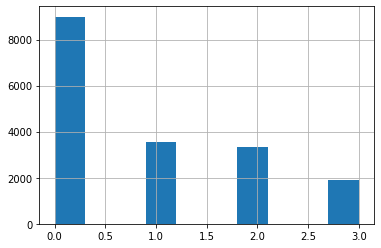

In [68]:
credit_encode['purpose'].hist()

In [69]:
credit_encode['debt'].value_counts()

0    16206
1     1542
Name: debt, dtype: int64

<AxesSubplot:>

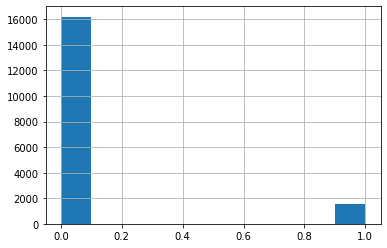

In [70]:
credit_encode['debt'].hist()

Dichotomize the categorical variable "purpose" and run a chi square test on each of the new dichotomous variables.  I will answer the question after running all four tests.

In [71]:
credit_encode['purpose0'] = credit_encode['purpose'] == 0
credit_encode['purpose1'] = credit_encode['purpose'] == 1
credit_encode['purpose2'] = credit_encode['purpose'] == 2
credit_encode['purpose3'] = credit_encode['purpose'] == 3

In [72]:
crosstab5 = pd.crosstab(credit_encode['debt'],
                        credit_encode['purpose0'], 
                               margins = True)
crosstab5

purpose0,False,True,All
debt,,,
0,7914,8292,16206
1,844,698,1542
All,8758,8990,17748


In [73]:
chi2_contingency(pd.crosstab(credit_encode.purpose0, credit_encode.debt))

(19.375667680750965,
 1.0736636599655694e-05,
 1,
 array([[7997.07843137,  760.92156863],
        [8208.92156863,  781.07843137]]))

In [74]:
crosstab6 = pd.crosstab(credit_encode['debt'],
                        credit_encode['purpose1'], 
                               margins = True)
crosstab6

purpose1,False,True,All
debt,,,
0,13021,3185,16206
1,1187,355,1542
All,14208,3540,17748


In [75]:
chi2_contingency(pd.crosstab(credit_encode.purpose1, credit_encode.debt))

(9.797796295317246,
 0.0017472112270018525,
 1,
 array([[12973.56592292,  1234.43407708],
        [ 3232.43407708,   307.56592292]]))

In [76]:
crosstab7 = pd.crosstab(credit_encode['debt'],
                        credit_encode['purpose2'], 
                               margins = True)
crosstab7

purpose2,False,True,All
debt,,,
0,13218,2988,16206
1,1215,327,1542
All,14433,3315,17748


In [77]:
chi2_contingency(pd.crosstab(credit_encode.purpose2, credit_encode.debt))

(6.9243705544259235,
 0.008502891456999203,
 1,
 array([[13179.01724138,  1253.98275862],
        [ 3026.98275862,   288.01724138]]))

In [78]:
crosstab8 = pd.crosstab(credit_encode['debt'],
                        credit_encode['purpose3'], 
                               margins = True)
crosstab8

purpose3,False,True,All
debt,,,
0,14465,1741,16206
1,1380,162,1542
All,15845,1903,17748


In [79]:
chi2_contingency(pd.crosstab(credit_encode.purpose3, credit_encode.debt))

(0.05977306702184015,
 0.8068549774179851,
 1,
 array([[14468.33840433,  1376.66159567],
        [ 1737.66159567,   165.33840433]]))

Recall the encoding as: 'for real estate transaction': 0, 'to buy a car': 1, 'to get an education': 2, 'to have a wedding': 3}
Based on the p-values of the 4 types of purposes above, only borrowing money to have a wedding does not seem to explain whether the borrower pays its debt on time or not.  These are the same results as in the first notebook.

General conclusion: Data is messy and missing values as well as duplicates need to be treated with care.  The tradeoff of dealing with them first, skews your data.  It would be interesting to see how starting with missing values changes the results of our hypothesis tests.  Categorizing data is art not science. Categorization affects the result.  The rule of thumb is to have as many categories as possible to maintain meaning in the data.  Substantively, some variables are associated with the dependent variable, payment of time, and others are not.  But we cannot say anything about the direction of this association.  It could be that people that pay on time are the ones who take loans in the first place.  Also, it would be interesting to look at the interaction effect of some of the independent variables.  It could be that some variables, when used in a univariate model do affect the dependent variable but that this effect is dampened if another variable is also in the model.  

Plan: to understand the missing data, we should look at it closely:
1- add up the msising data by variable
2- create a dataframe with these rows with missing variables
3- unique them to check if all the missing values are nans

Conclusion: Interestingly, the same observations have both variables missing.  This means the patterns of missing variables is not random and hence is problematic.  The contents of the cells with missing variables are all nans.